<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#RandomForrestRegressor" data-toc-modified-id="RandomForrestRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RandomForrestRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import torch

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Сделаем наши временные отсчеты индексами

In [3]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [4]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


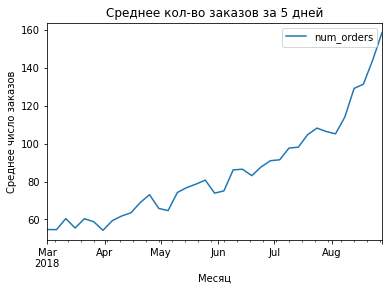

In [5]:
df.resample('5D').mean().plot()
plt.title('Среднее кол-во заказов за 5 дней')
plt.xlabel('Месяц')
plt.ylabel('Среднее число заказов')
plt.show()

Видим, что со временем года, кол-во закатов пропорционально увеличивается

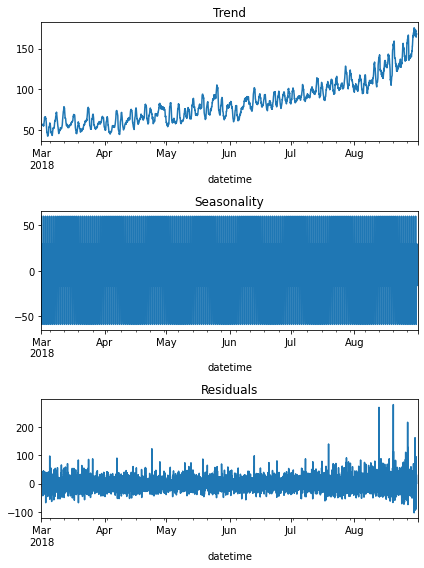

In [6]:
df_day = df.resample('1H').sum()
decomposed = seasonal_decompose(df_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

Т.к. мы имеем сильно ограниченную временем выборку, нам сложно оценить тренды и сезонность, однако видим, что имеется шумовая состовляющая в сигнале, учтем это при добавлении признаков к нашему датасету

## Обучение

In [7]:
def make_features(data, max_lag, rolling_mean_size):
    new_df = data.copy()
    new_df['year'] = new_df.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_df


In [8]:
new_data = make_features(df, 25, 1)
new_data = new_data.dropna()
new_data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 01:00:00,120,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,90.0
2018-03-02 02:00:00,75,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,120.0
2018-03-02 03:00:00,64,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,75.0
2018-03-02 04:00:00,20,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,64.0
2018-03-02 05:00:00,11,2018,3,2,4,20.0,64.0,75.0,120.0,90.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,20.0


In [9]:
train, test = train_test_split(new_data, shuffle=False, test_size=0.1)

In [10]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)

Разделили выборки на обучающую и тестовую, добавили признаки, можно обучать модели

### RandomForrestRegressor

In [11]:
%%time
rfr = RandomForestRegressor(random_state=12345)#Исследуем модель дерева решений
param_grid_rfr = { # словарь параметров
    'max_depth':[5,7,9,11,13],
    'min_samples_leaf':[2,4],    
    'n_estimators': [10, 20, 30]    
}
tscv = TimeSeriesSplit()

#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_rfr = GridSearchCV(estimator=rfr,
                       param_grid=param_grid_rfr,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error'
)
grid_CV_rfr.fit(features_train, target_train)


print(grid_CV_rfr.best_score_)

-26.085608420800277
CPU times: user 1min 8s, sys: 157 ms, total: 1min 8s
Wall time: 1min 22s


### LightGBM

In [ ]:
%%time
lgbmr = LGBMRegressor(random_state=12345)
param_grid_lgbmr = { # словарь параметров
    'max_depth':[5,7,9,11],
    'num_leaves':[20,40, 50, 60]
        
}
tscv = TimeSeriesSplit()
#воспользуемся методом GridSearchCV для подбора параметров
grid_CV_lgbmr = GridSearchCV(estimator=lgbmr,
                       param_grid=param_grid_lgbmr,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error'
)
grid_CV_lgbmr.fit(features_train, target_train)

print(abs(grid_CV_lgbmr.best_score_))

## Тестирование

In [12]:
test_preds = grid_CV_rfr.best_estimator_.predict(features_test)

print('RMSE = ', mean_squared_error(test['num_orders'], test_preds)**0.5)

RMSE =  45.00531117808245


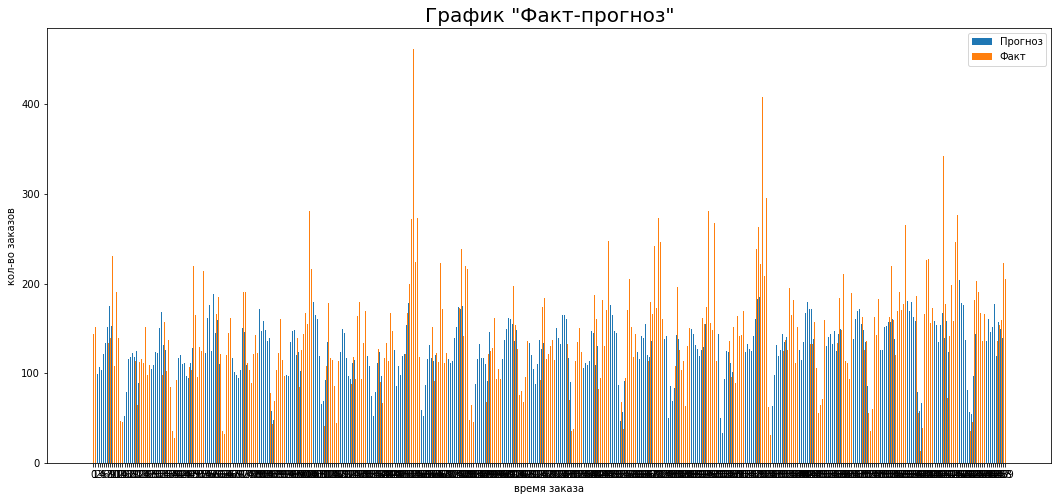

In [14]:
y1 = test_preds
y2 = test['num_orders']
x  = np.arange(len(y1))

fig,ax = plt.subplots()
fig.set_figwidth(18)
fig.set_figheight(8)
ax.set_xticks(x)
first = ax.bar(x-0.15, y1, width = 0.3, label = 'Прогноз')
second = ax.bar(x+0.15, y2, width = 0.3, label = 'Факт')
ax.legend()
ax.set_title('График "Факт-прогноз"', fontsize=20)
ax.set_xlabel('время заказа')
ax.set_ylabel('кол-во заказов')
plt.show()

Добились необходимого значения нашей метрики.

## Выводы

В данном проекте мы сделали следующее:
- Провели анализ нашего временного ряда
- Добавили признаки, чтобы обучить нашу модель
- Обучили нашу модель, добились нужного значения метрики на тестовой выборке